In [ ]:
import pandas as pd
import tensorflow as tf

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!unzip \*.zip

Archive:  archive (2).zip
  inflating: file1.csv               


In [ ]:
# Convert the dataset into a dataframe and drop the data that will not be used on the model
df = pd.read_csv('file1.csv')
df.rename(columns = {'statement' : 'sentence'}, inplace = True)

In [ ]:
# Process Data (One Hot Encoding)
category = pd.get_dummies(df.type)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='type')
df_new

,sentence,command,question,statement
0,and confirm that address for me please,1,0,0
1,it's from Birmingham to em London Euston please,0,0,1
2,the 8th of October,0,0,1
3,i'd like to leave on the 7:33 train,0,0,1
4,there's the 7:33 from Birmingham New Street,0,0,1
...,...,...,...,...
210061,Come please,1,0,0
210062,Come on!,1,0,0
210063,Come on,1,0,0
210064,Don't eat so much.,1,0,0


In [ ]:
# Change to numpy array
sentence = df_new['sentence'].values
label = df_new[['command',	'question',	'statement']].values

In [ ]:
# Split Data
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2)

In [ ]:
# Convert every word in the dataset to a number
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(sentence_train) 
tokenizer.fit_on_texts(sentence_test)
 
sequences_train = tokenizer.texts_to_sequences(sentence_train)
sequences_test = tokenizer.texts_to_sequences(sentence_test)
 
padded_train = pad_sequences(sequences_train) 
padded_test = pad_sequences(sequences_test)

In [ ]:
# The Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         20608     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [ ]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Train the Model
num_epochs = 10
batch = 50
history = model.fit(padded_train,
                    label_train,
                    epochs=num_epochs,
                    batch_size = batch, 
                    validation_data=(padded_test, label_test),
                    verbose=1,
                    callbacks=[callbacks])

Epoch 1/10
3362/3362 [==============================] - 170s 41ms/step - loss: 0.2045 - accuracy: 0.9215 - val_loss: 0.1466 - val_accuracy: 0.9454
Epoch 2/10
3362/3362 [==============================] - 135s 40ms/step - loss: 0.1436 - accuracy: 0.9465 - val_loss: 0.1347 - val_accuracy: 0.9508
Epoch 3/10
3362/3362 [==============================] - 127s 38ms/step - loss: 0.1183 - accuracy: 0.9563 - val_loss: 0.1351 - val_accuracy: 0.9503

Reached 95.0% accuracy so cancelling training!


<Figure size 432x288 with 0 Axes>

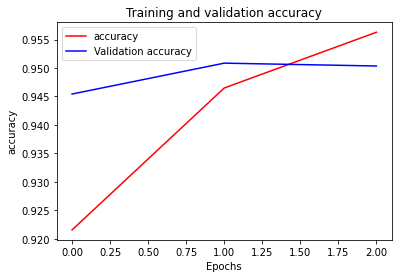

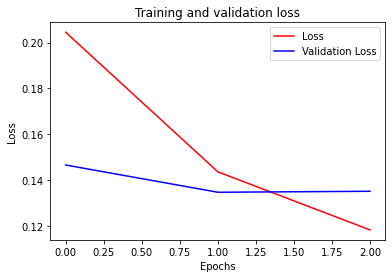

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training and validation loss per epoch
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(accuracy)) 

plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "Validation accuracy"])

plt.figure()


plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()